In [2]:
import os
import random
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#For local jum002 HPC setup
import sys
sys.path.append("/home/jum002/store5/repo/smrt_fork/smrt")
sys.path.append("/home/jum002/store5/repo/snowmicropyn")

#local import 
import akross_common_functions as AK

# Import saline snow permittivity model
from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp
#from smrt.permittivity.saline_snow import saline_snow_permittivity_geldsetzer09 as ssp

from smrt import make_ice_column, make_snowpack
from smrt.core.globalconstants import PSU
from smrt import make_model
from smrt.inputs import altimeter_list
from smrt.emmodel.iba import derived_IBA

#turn off warning
import warnings
warnings.simplefilter('ignore')

This notebook contains the following 4 sections

1. Prepare simulation
2. Signal contribution (surface, interface and volume)
3. Sensitivity analysis for Ku
4. Sensitivity analysis for Ka

### 1. Prepare simulation

- import profile derived from smp ready to create SMRT simulation.
- CB and Eureka22 an join together to represent FYI. A random subset from eureka (500 snowpacks) is taken of same size from CB. This is just to allow faster simulation.

In [3]:
#CB
#get smp profile for CB
with open('smrt_in-out/smp_profile_CB_3cm', 'rb') as pickle_file:
    smp_CB = pd.read_pickle('smrt_in-out/smp_profile_CB_3cm')

#restructure to list of profile
# Flatten dict of dicts
list_smp_CB = [profile for site, item in smp_CB.items() for name, profile in item.items()]

FYI_sp = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14)

# #Eureka
# # Get list of sites (upper folders)
# # Data from https://doi.org/10.5281/zenodo.4068349
# #data_dir = '../DATA/SMP/Sites'
# data_dir = '/home/jum002/store5/data/SMP/Sites'
# list_of_sites = os.listdir(path=data_dir)
# # Split Eureka and Alert sites
# eureka_sites = [s for s in list_of_sites if 'Eureka' in s]

# #get smp profile for Eureka
# E_smp_files,  E_smp_sites = [], []
# for s in eureka_sites:
#     E_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir)[0])
#     E_smp_sites.append(AK.find_site_smp_files(s, data_dir = data_dir)[1])

# # Flatten list of lists
# eureka_smp_files = list(itertools.chain(*E_smp_files))
# eureka_smp_sites = list(itertools.chain(*E_smp_sites))
# #get only FYI
# eureka_smp_fyi_files = [files for files in zip(eureka_smp_files, eureka_smp_sites) if 'FYI' in files[0]]



In [4]:

salt_dict = pd.read_pickle('smrt_in-out/alert_eureka_salt_dict')
temp_dict = pd.read_pickle('smrt_in-out/alert_eureka_temp_dict')

In [5]:
#Get MYI snowpack from Alert
# Get list of sites (upper folders)
# Data from https://doi.org/10.5281/zenodo.4068349
#data_dir = '../DATA/SMP/Sites'
#data_dir = 'C:/Users/melochej/Documents/code-workshop/AKROSS/DATA/SMP/Sites'
data_dir = '/home/jum002/store5/data/SMP/Sites'
list_of_sites = os.listdir(path=data_dir)
alert_sites = [s for s in list_of_sites if 'Alert' in s]

A_smp_files, A_smp_sites = [], []
for s in alert_sites:
    A_smp_files.append(AK.find_site_smp_files(s, data_dir = data_dir)[0])
    A_smp_sites.append(AK.find_site_smp_files(s, data_dir = data_dir)[1])
# Flatten list of lists
alert_smp_files = list(itertools.chain(*A_smp_files))
alert_smp_sites = list(itertools.chain(*A_smp_sites))

MYI_sp = AK.smp_snowpacks(alert_smp_files, alert_smp_sites, salt_dict, temp_dict, layer_thickness=0.03, rough=False, permittivity = None,
                        sea_ice_density=880, sigma_surface = 0.22)


make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1884.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1886.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1885.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1869.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1870.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1867.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1879.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1876.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1877.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1871.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1875.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert

In [6]:
#set mean roughness value for snow and ice from AKROSS campaign

# value of ice optimized per (FYI=  mean of CB-Eureka 22 and Eureka 16, MYI = Alert)
mean_rms_fyi = 0.0015
mean_rms_myi = 0.0059
mean_lc_fyi = 0.6
mean_lc_myi = 0.6

#norm factor from notebook 3.1
normf = 8.553129203264525e-10


In [7]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(return_contributions=True, theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto"))
cryosat = altimeter_list.cryosat2_sin()
altika = altimeter_list.saral_altika()

### 2. Signal contribution

- investigate signal contribution as a function of ice roughness
- check signal contribution at optimized roughness
- plot the results

In [8]:
#Ku
#investigate contribution as function of roughness
rough_array = np.linspace(0.001,0.007, 10)
rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:
    #add salt for Alert
    AK.change_roughness(MYI_sp, rough, mean_lc_myi, rough, mean_lc_myi)
    AK.change_roughness(FYI_sp, rough, mean_lc_fyi, rough, mean_lc_fyi)

    #simulate Ku and Ka
    res_A_Ku = altimodel.run(cryosat, MYI_sp, parallel_computation=True).sigma()
    res_CB_Ku = altimodel.run(cryosat, FYI_sp, parallel_computation=True).sigma()

    mean_simu_A_Ku = np.mean(res_A_Ku, axis = 0)/normf
    mean_simu_CB_Ku = np.mean(res_CB_Ku, axis = 0)/normf

    interface_myi_ku = AK.calc_A(mean_simu_A_Ku.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_A_Ku.sel(contribution = 'total').values) *100
    surface_myi_ku = AK.calc_A(mean_simu_A_Ku.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_A_Ku.sel(contribution = 'total').values) *100
    volume_myi_ku = AK.calc_A(mean_simu_A_Ku.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_A_Ku.sel(contribution = 'total').values) *100

    interface_fyi_ku = AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
    surface_fyi_ku = AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
    volume_fyi_ku = AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'total').values) *100 

    rough_contribution_A.append({'interface': interface_myi_ku, 'surface' : surface_myi_ku, 'volume' : volume_myi_ku})
    rough_contribution_CB.append({'interface': interface_fyi_ku, 'surface' : surface_fyi_ku, 'volume' : volume_fyi_ku})
rough_df_A_ku = pd.DataFrame(rough_contribution_A)
rough_df_CB_ku = pd.DataFrame(rough_contribution_CB)

In [9]:
#Ka
#investigate contribution as function of roughness
rough_array = np.linspace(0.001,0.007, 10)
rough_contribution_A, rough_contribution_CB = [], []
for rough in rough_array:
    print(rough)
    #add salt for Alert
    AK.change_roughness_geo(MYI_sp, rough, mean_lc_myi, rough, mean_lc_myi)
    AK.change_roughness_geo(FYI_sp, rough, mean_lc_fyi, rough, mean_lc_fyi)

    #simulate Ku and Ka
    res_A_Ka = altimodel.run(altika, MYI_sp, parallel_computation=True).sigma()
    res_CB_Ka = altimodel.run(altika, FYI_sp, parallel_computation=True).sigma()

    mean_simu_A_Ka = np.mean(res_A_Ka, axis = 0)/normf
    mean_simu_CB_Ka = np.mean(res_CB_Ka, axis = 0)/normf

    interface_myi_ka = AK.calc_A(mean_simu_A_Ka.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_A_Ka.sel(contribution = 'total').values) *100
    surface_myi_ka = AK.calc_A(mean_simu_A_Ka.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_A_Ka.sel(contribution = 'total').values) *100
    volume_myi_ka = AK.calc_A(mean_simu_A_Ka.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_A_Ka.sel(contribution = 'total').values) *100

    interface_fyi_ka = AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
    surface_fyi_ka = AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
    volume_fyi_ka = AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'total').values) *100 

    rough_contribution_A.append({'interface': interface_myi_ka, 'surface' : surface_myi_ka, 'volume' : volume_myi_ka})
    rough_contribution_CB.append({'interface': interface_fyi_ka, 'surface' : surface_fyi_ka, 'volume' : volume_fyi_ka})
rough_df_A_ka = pd.DataFrame(rough_contribution_A)
rough_df_CB_ka = pd.DataFrame(rough_contribution_CB)

0.001


/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))
/home/jum002/store5/repo/smrt_fork/smrt/smrt/interface/geometrical_o

0.0016666666666666666
0.002333333333333333
0.003
0.0036666666666666666
0.004333333333333333
0.005
0.005666666666666666
0.006333333333333333
0.007


get contribution at optimized roughness

In [10]:
#Ku
#add salt for Alert
AK.change_roughness(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

#simulate Ku and Ka
res_A_Ku = altimodel.run(cryosat, MYI_sp, parallel_computation=True).sigma()
res_CB_Ku = altimodel.run(cryosat, FYI_sp, parallel_computation=True).sigma()

mean_simu_A_Ku = np.mean(res_A_Ku, axis = 0)/normf
mean_simu_CB_Ku = np.mean(res_CB_Ku, axis = 0)/normf

interface_myi_ku = AK.calc_A(mean_simu_A_Ku.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_A_Ku.sel(contribution = 'total').values) *100
surface_myi_ku = AK.calc_A(mean_simu_A_Ku.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_A_Ku.sel(contribution = 'total').values) *100
volume_myi_ku = AK.calc_A(mean_simu_A_Ku.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_A_Ku.sel(contribution = 'total').values) *100

interface_fyi_ku = AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
surface_fyi_ku = AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'total').values) *100
volume_fyi_ku = AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_CB_Ku.sel(contribution = 'total').values) *100

In [11]:
#Ka
#add salt for Alert
AK.change_roughness_geo(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness_geo(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

#simulate Ku and Ka
res_A_Ka = altimodel.run(altika, MYI_sp, parallel_computation=True).sigma()
res_CB_Ka = altimodel.run(altika, FYI_sp, parallel_computation=True).sigma()

mean_simu_A_Ka = np.mean(res_A_Ka, axis = 0)/normf
mean_simu_CB_Ka = np.mean(res_CB_Ka, axis = 0)/normf

interface_myi_ka = AK.calc_A(mean_simu_A_Ka.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_A_Ka.sel(contribution = 'total').values) *100
surface_myi_ka = AK.calc_A(mean_simu_A_Ka.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_A_Ka.sel(contribution = 'total').values) *100
volume_myi_ka = AK.calc_A(mean_simu_A_Ka.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_A_Ka.sel(contribution = 'total').values) *100

interface_fyi_ka = AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'interfaces').values) / AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
surface_fyi_ka = AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'surface').values) / AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'total').values) *100
volume_fyi_ka = AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'volume').values) / AK.calc_A(mean_simu_CB_Ka.sel(contribution = 'total').values) *100

plot the results

In [12]:
df = pd.DataFrame({'Ice type - sensor' : ['CB 22 - Ku band', 'Alert 17 - Ku band', 'CB 22 - Ka band', 'Alert 17 - Ka band'], 
             'surface': [surface_fyi_ku, surface_myi_ku, surface_fyi_ka, surface_myi_ka],
             'interface' : [interface_fyi_ku, interface_myi_ku, interface_fyi_ka, interface_myi_ka],
             'volume' : [volume_fyi_ku, volume_myi_ku, volume_fyi_ka, volume_myi_ka] })

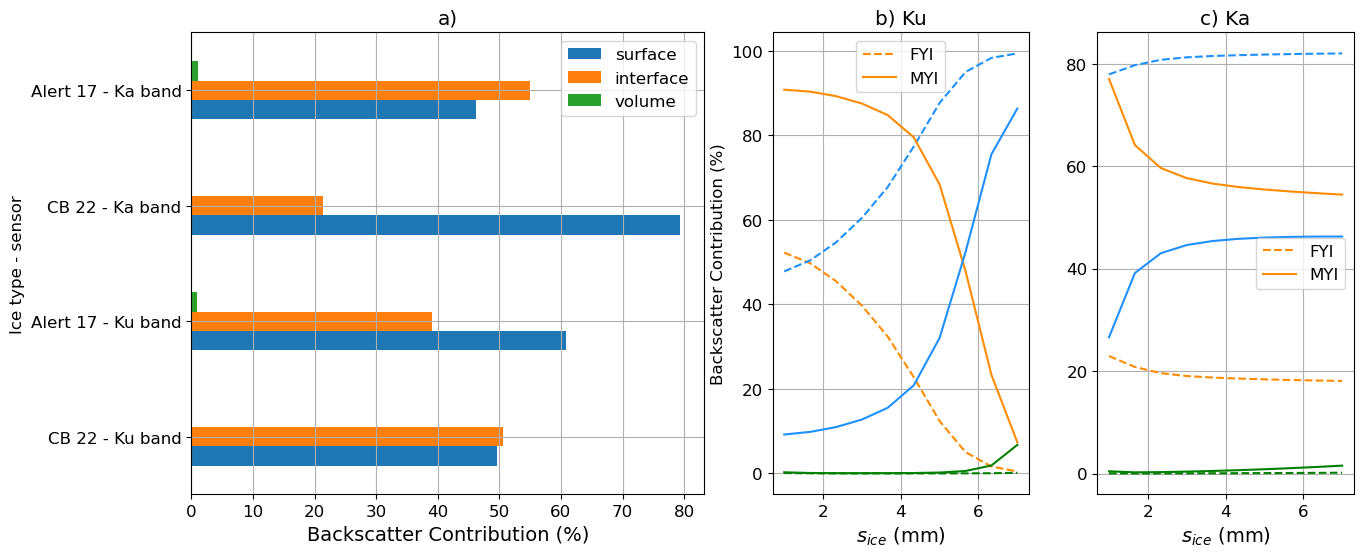

In [13]:
plt.rcParams.update({'font.size': 12})
fig, (ax1, ax2, ax3)  = plt.subplots(nrows=1, ncols=3, figsize=(15,6), gridspec_kw={'width_ratios': [2, 1, 1]})
df.plot(
    x = 'Ice type - sensor',
    kind = 'barh',
    stacked = False,
    title = 'a)',
    ax =ax1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Backscatter Contribution (%)', size =14)

ax2.plot(rough_array*1000,rough_df_CB_ku.interface,'--', label = 'FYI', color = 'darkorange')
ax2.plot(rough_array*1000,rough_df_CB_ku.surface,'--', color = 'dodgerblue')
ax2.plot(rough_array*1000,rough_df_CB_ku.volume,'--', color = 'green')
ax2.legend()
ax2.plot(rough_array*1000,rough_df_A_ku.interface, label = 'MYI', color = 'darkorange')
ax2.plot(rough_array*1000,rough_df_A_ku.surface, color = 'dodgerblue')
ax2.plot(rough_array*1000,rough_df_A_ku.volume, color = 'green')
ax2.legend()
ax2.set_title('b) Ku')
ax2.set_xlabel('$s_{ice}$ (mm)', size =14)
ax2.set_ylabel('Backscatter Contribution (%)', size =12)
ax2.grid()
#plt.subplots_adjust(wspace= 0.6)
#plt.xlim(-2,105)
ax3.plot(rough_array*1000,rough_df_CB_ka.interface,'--', label = 'FYI', color = 'darkorange')
ax3.plot(rough_array*1000,rough_df_CB_ka.surface,'--', color = 'dodgerblue')
ax3.plot(rough_array*1000,rough_df_CB_ka.volume,'--', color = 'green')
ax3.legend()
ax3.plot(rough_array*1000,rough_df_A_ka.interface, label = 'MYI', color = 'darkorange')
ax3.plot(rough_array*1000,rough_df_A_ka.surface, color = 'dodgerblue')
ax3.plot(rough_array*1000,rough_df_A_ka.volume, color = 'green')
ax3.legend()
ax3.set_title('c) Ka')
ax3.set_xlabel('$s_{ice}$ (mm)', size =14)
#ax3.set_ylabel('Backscatter Contribution (%)', size =12)
ax3.grid()

#plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/contribution_Ku_ka.png', dpi=300, format='png', bbox_inches='tight')

### 3. sensitivity analysis for Ku

- New simulation are produced, introducing a variation (i.e ± 5 K for temperature) from the measured data (simulation intoduced earlier)
- A lot of functions are introduced to be able to regenerate modified simulation. Some parameters needed different function and tricks to achieve
- Results are plotted against simulation introduced earlier in section 3.1


Lets define the functions that produce modified simulations

In [15]:

MYI_ice = make_ice_column(ice_type='firstyear',
                    thickness=[2], temperature=260, 
                    microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=910,
                    salinity=5*PSU,
                    add_water_substrate=True)
FYI_ice = make_ice_column(ice_type='multiyear',
                    thickness=[3], temperature=260, microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=880,
                    salinity=5*PSU,
                    add_water_substrate=True)

def debye_calc(ssa, density):
    return 4 * (1 - density / 917) / (ssa * 917)

def change_snowpack(ratio, list_snowpack, mean_rms, mean_lc, param, sigma_surface = 0.14, Ka = False):
    """
    get info from original snowpack
    modified the param  (thickness, ssa or salinity) using a ratio from original measurements
    return modified snowpack
    """
    new_snow = [sp.deepcopy() for sp in list_snowpack]
    
    for sp in new_snow:
        sp.sigma_surface = sigma_surface


    if Ka == True:
        AK.change_roughness_geo(new_snow, mean_rms, mean_lc, mean_rms, mean_lc)
    else:
        AK.change_roughness(new_snow, mean_rms, mean_lc, mean_rms, mean_lc)

    for i in range(0, len(new_snow)): 
        snow_layers = new_snow[i].nlayer - 1
        if param == 'thick':
            for n in np.arange(snow_layers):
                new_snow[i].layers[n].thickness = new_snow[i].layers[n].thickness * ratio
        if param == 'ssa':
            for n in np.arange(snow_layers):
                #apply change to ssa therefore corrL
                corrL_change = debye_calc(new_snow[i].layers[n].ssa*ratio , new_snow[i].layers[n].density)
                new_snow[i].layers[n].microstructure.corr_length = corrL_change
        if param == 'salinity':
            #apply change to salinity 
            for n in np.arange(snow_layers):
                new_snow[i].layers[-n].salinity = new_snow[i].layers[-n].salinity * ratio
            
    return new_snow

In [16]:
# change density in snowpack, needs a special function because denisty cannot be modify once snowpack is made
def change_density_temp(list_snowpack, ratio, temp_shift, mean_rms, mean_lc, sigma_surface = 0.14, Ka = False):
    """
    redefine snowpack from scratch because density and temperautre are read only (cannot be modified)
    ratio :  modified density with this ratio
    temp_shift :  add or reduce temperature
    return modified snowpack
    """
    new_snow = [sp.deepcopy() for sp in list_snowpack]

    for sp in new_snow:
        sp.sigma_surface = sigma_surface

    if Ka == True:
        AK.change_roughness_geo(new_snow, mean_rms, mean_lc, mean_rms, mean_lc)
    else:
        AK.change_roughness(new_snow, mean_rms, mean_lc, mean_rms, mean_lc)

    for sp in new_snow: 
        new_density = [layer.density * ratio for layer in sp.layers[:-1]]
        for id, density in enumerate(new_density):
            sp.layers[id].update(density = density)

        new_temp = [layer.temperature + temp_shift if layer.temperature + temp_shift > 251 else 251 for layer in sp.layers[:-1]]
        for id, temp in enumerate(new_temp):
            sp.layers[id].update(temperature = temp)

    return new_snow

In [58]:
def avg_snow_sum_thick(snow_df):
    thick = snow_df.thickness.sum()
    snow_mean = snow_df.apply(lambda x: np.average(x, weights = snow_df.thickness.values), axis =0)
    snow_mean['thickness'] = thick

    return snow_mean

def three_layer(snow_df):
    #get norm height
    snow_df.loc[:,'norm_h'] = snow_df.height/snow_df.thickness.sum()
    #split by third and average
    snow_1 = avg_snow_sum_thick(snow_df[snow_df.norm_h >= 0.66])
    snow_2 = avg_snow_sum_thick(snow_df[(snow_df.norm_h <= 0.66) & (snow_df.norm_h >= 0.34)]) 
    snow_3 = avg_snow_sum_thick(snow_df[snow_df.norm_h < 0.34]) 
    
    return pd.DataFrame([df for df in [snow_1, snow_2, snow_3] if not df.empty])

def reduce_layer(list_snowpack, layer, type_ice, Ka = False):

    new_snow = []
    for sp in list_snowpack: 
        snow_df = sp.to_dataframe().layer.iloc[:-2].drop(['microstructure_model', 'ice_type'], axis = 1)
        snow_df['porod_length'] = sp.to_dataframe().microstructure.porod_length[:-2]
        snow_df['polydispersity'] = sp.to_dataframe().microstructure.polydispersity[:-2]
        snow_df['height'] = np.cumsum(snow_df.thickness.values)[::-1]
           
        if type_ice == 'FYI':
            mean_rms = mean_rms_fyi
            mean_lc = mean_lc_fyi
            ice = FYI_ice
            sigma_surface = 0.14

        else:
            mean_rms = mean_rms_myi
            mean_lc = mean_lc_myi
            ice = MYI_ice
            sigma_surface = 0.22

        if layer == 'one':
            snow_one = avg_snow_sum_thick(snow_df)
            snowpack = make_snowpack([snow_one.thickness], microstructure_model='unified_scaled_exponential',
                        density=snow_one.density , 
                        porod_length=snow_one.porod_length,
                        temperature = snow_one.temperature,
                        salinity=snow_one.salinity,
                        polydispersity = snow_one.polydispersity) + ice
            snowpack.sigma_surface = sigma_surface
            new_snow.append(snowpack)

        if layer == 'three':
            snow_three = three_layer(snow_df)
            snowpack = make_snowpack(snow_three.thickness, microstructure_model='unified_scaled_exponential',
                        density=snow_three.density , 
                        porod_length=snow_three.porod_length,
                        temperature = snow_three.temperature,
                        salinity=snow_three.salinity,
                        polydispersity = snow_three.polydispersity) + ice
            snowpack.sigma_surface = sigma_surface
            new_snow.append(snowpack)

    if Ka == True:
        AK.change_roughness_geo(new_snow, mean_rms, mean_lc, mean_rms, mean_lc)
    else:
        AK.change_roughness(new_snow, mean_rms, mean_lc, mean_rms, mean_lc)

    return new_snow

Create modified snowpack

In [59]:
#reset roughness to IEM for Ku
AK.change_roughness(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

In [60]:
#Depth
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_depth_p50 = change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14)
CB_depth_m50 = change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14)

#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_depth_p50 = change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22)
A_depth_m50 = change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22)

In [61]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_ssa_p20 = change_snowpack(1.2, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14)
CB_ssa_m20 = change_snowpack(0.8, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_ssa_p20 = change_snowpack(1.2, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22)
A_ssa_m20 = change_snowpack(0.8, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22)

In [62]:
#temperature
CB_temp_p10 = change_density_temp(FYI_sp, 1, 5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
CB_temp_m10 = change_density_temp(FYI_sp, 1, -5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
A_temp_p10 = change_density_temp(MYI_sp, 1, 5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
A_temp_m10 = change_density_temp(MYI_sp, 1, -5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
# CB_temp_p10 = change_density_temp(FYI_sp, 1, 10, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
# CB_temp_m10 = change_density_temp(FYI_sp, 1, -10, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
# A_temp_p10 = change_density_temp(MYI_sp, 1, 10, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
# A_temp_m10 = change_density_temp(MYI_sp, 1, -10, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)

In [63]:
#Density
CB_density_p50 = change_density_temp(FYI_sp, 1.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
CB_density_m50 = change_density_temp(FYI_sp, 0.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14)
A_density_p50 = change_density_temp(MYI_sp, 1.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)
A_density_m50 = change_density_temp(MYI_sp, 0.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22)

In [64]:
#Salt of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_salt_p50 = change_snowpack(1.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14)
CB_salt_m50 = change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_salt_p50 = change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi,'salinity', sigma_surface=0.22)
A_salt_m50 = change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi,'salinity', sigma_surface=0.22)

In [65]:
                
#roughness
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_s_p1 = change_snowpack(1, FYI_sp, mean_rms_fyi + 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14)
CB_rough_s_m1 = change_snowpack(1, FYI_sp, mean_rms_fyi - 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_s_p1 = change_snowpack(1, MYI_sp, mean_rms_myi + 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22)
A_rough_s_m1 = change_snowpack(1, MYI_sp, mean_rms_myi - 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22)

In [66]:
#roughness
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_l_p1 = change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi+ 0.3, 'ssa', sigma_surface=0.14)
CB_rough_l_m1 = change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi- 0.3, 'ssa', sigma_surface=0.14)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_l_p1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi + 0.3, 'ssa', sigma_surface=0.22)
A_rough_l_m1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi - 0.3, 'ssa', sigma_surface=0.22)

In [67]:
# #sigma surface
# #call snowpack fromm scratch with build_snowpack so FYI_sp not modify
# CB_rough_l_p1 = change_snowpack(1, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.0)
# CB_rough_l_m1 = change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.8)

# #call snowpack fromm scratch with build_snowpack so A_sp not modify
# A_rough_l_p1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.02)
# A_rough_l_m1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.8)

In [68]:
#ice volume fration
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify

CB_vf_p1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*1.5)
CB_vf_m1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*0.5)
AK.change_roughness(CB_vf_p1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
AK.change_roughness(CB_vf_m1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_vf_p1 = AK.smp_snowpacks(alert_smp_files, alert_smp_sites, salt_dict, temp_dict, layer_thickness=0.03, sea_ice_density=917, sigma_surface = 0.22)
A_vf_m1 = AK.smp_snowpacks(alert_smp_files, alert_smp_sites, salt_dict, temp_dict, layer_thickness=0.03, sea_ice_density=880*0.95, sigma_surface = 0.22)
AK.change_roughness(A_vf_p1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness(A_vf_m1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)

make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1884.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1886.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1885.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1869.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1870.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1867.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1879.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1876.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1877.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1871.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1875.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert

In [69]:
#reduce layers
CB_one = reduce_layer(FYI_sp, 'one', 'FYI')
CB_three = reduce_layer(FYI_sp, 'three', 'FYI')

A_one = reduce_layer(MYI_sp, 'one', 'MYI')
A_three = reduce_layer(MYI_sp, 'three', 'MYI')

get modified waveform from modified snowpack

In [70]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto"))
cryosat = altimeter_list.cryosat2_sin()
res_CB_Ku_depth_p50 = np.mean(altimodel.run(cryosat, CB_depth_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_depth_m50 = np.mean(altimodel.run(cryosat, CB_depth_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_depth_p50 = np.mean(altimodel.run(cryosat, A_depth_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_depth_m50 = np.mean(altimodel.run(cryosat, A_depth_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_ssa_p20 = np.mean(altimodel.run(cryosat, CB_ssa_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_ssa_m20 = np.mean(altimodel.run(cryosat, CB_ssa_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_ssa_p20 = np.mean(altimodel.run(cryosat, A_ssa_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_ssa_m20 = np.mean(altimodel.run(cryosat, A_ssa_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_temp_p10 = np.mean(altimodel.run(cryosat, CB_temp_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_temp_m10 = np.mean(altimodel.run(cryosat, CB_temp_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_temp_p10 = np.mean(altimodel.run(cryosat, A_temp_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_temp_m10 = np.mean(altimodel.run(cryosat, A_temp_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_density_p50 = np.mean(altimodel.run(cryosat, CB_density_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_density_m50 = np.mean(altimodel.run(cryosat, CB_density_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_density_p50 = np.mean(altimodel.run(cryosat, A_density_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_density_m50 = np.mean(altimodel.run(cryosat, A_density_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_salt_p50 = np.mean(altimodel.run(cryosat, CB_salt_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_salt_m50 = np.mean(altimodel.run(cryosat, CB_salt_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_salt_p50 = np.mean(altimodel.run(cryosat, A_salt_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_salt_m50 = np.mean(altimodel.run(cryosat, A_salt_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_rough_s_p1 = np.mean(altimodel.run(cryosat, CB_rough_s_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_rough_s_m1 = np.mean(altimodel.run(cryosat, CB_rough_s_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_s_p1 = np.mean(altimodel.run(cryosat, A_rough_s_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_s_m1 = np.mean(altimodel.run(cryosat, A_rough_s_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_rough_l_p1 = np.mean(altimodel.run(cryosat, CB_rough_l_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_rough_l_m1 = np.mean(altimodel.run(cryosat, CB_rough_l_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_l_p1 = np.mean(altimodel.run(cryosat, A_rough_l_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_rough_l_m1 = np.mean(altimodel.run(cryosat, A_rough_l_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_vf_p1 = np.mean(altimodel.run(cryosat, CB_vf_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_vf_m1 = np.mean(altimodel.run(cryosat, CB_vf_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_vf_p1 = np.mean(altimodel.run(cryosat, A_vf_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_vf_m1 = np.mean(altimodel.run(cryosat, A_vf_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ku_one = np.mean(altimodel.run(cryosat, CB_one, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ku_three = np.mean(altimodel.run(cryosat, CB_three, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_one = np.mean(altimodel.run(cryosat, A_one, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ku_three = np.mean(altimodel.run(cryosat, A_three, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

plot results

(0.1, 10)

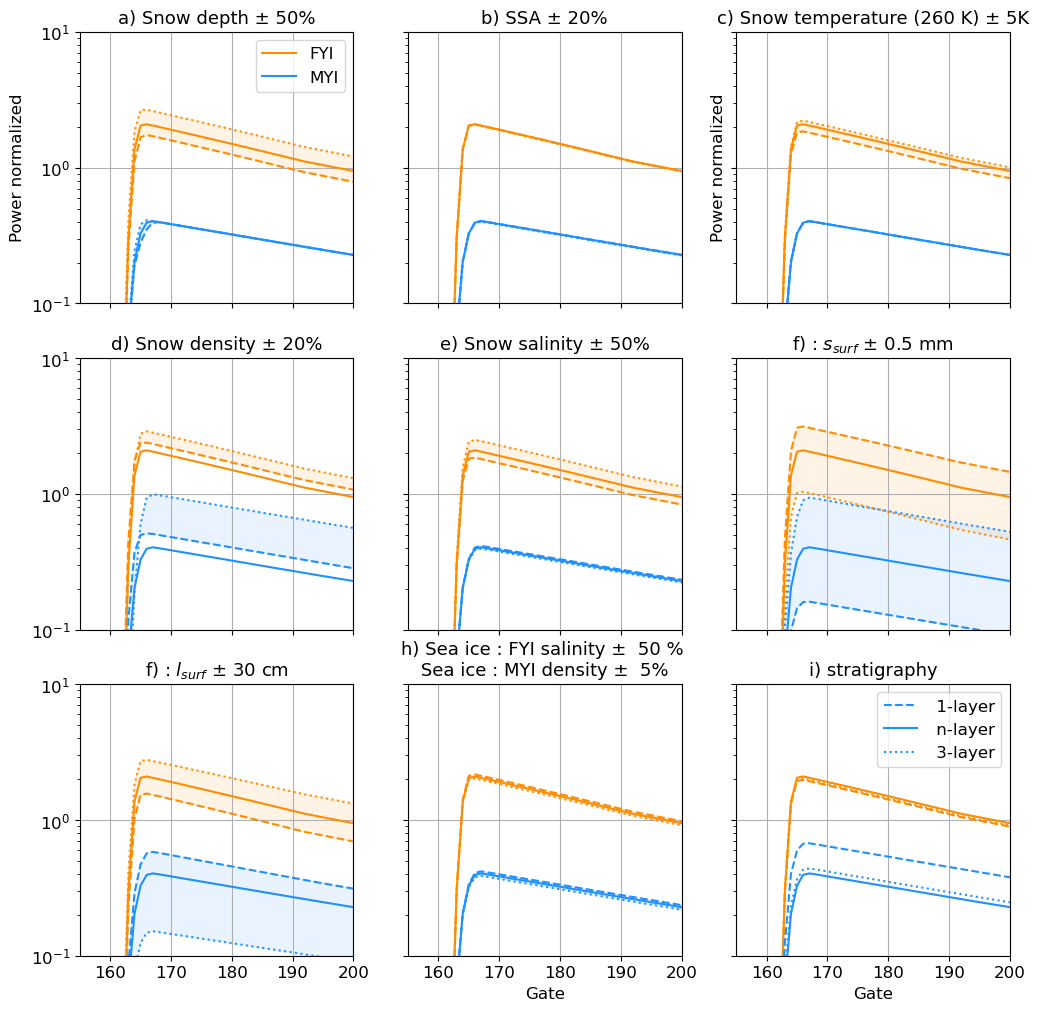

In [71]:
#generate x fro number of bins
x = range(0,len(res_CB_Ku_depth_p50))

# Plot results
plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(12,12),
                                                                         sharey =True, sharex = True)
plt.rcParams.update({'font.size': 12})
ax1.set_title('a) Snow depth ± 50%', size = 13)
ax1.plot(res_CB_Ku_depth_p50, linestyle = '--',color = 'darkorange')
ax1.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI')
ax1.plot(res_CB_Ku_depth_m50, linestyle = ':',color = 'darkorange')
ax1.fill_between(x, y1 = res_CB_Ku_depth_p50, y2 = res_CB_Ku_depth_m50, alpha =0.1, color = 'darkorange')

ax1.plot(res_A_Ku_depth_p50, linestyle = '--',color = 'dodgerblue')
ax1.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI')
ax1.plot(res_A_Ku_depth_m50, linestyle = ':',color = 'dodgerblue')
ax1.fill_between(x, y1 = res_A_Ku_depth_p50, y2 = res_A_Ku_depth_m50, alpha =0.1, color = 'dodgerblue')
ax1.legend()
ax1.set_xlim(155,190)
ax1.set_ylabel('Power normalized')
ax1.set_yscale('log')
ax1.grid()


ax2.set_title('b) SSA ± 20%', size = 13)
ax2.plot(res_CB_Ku_ssa_p20, linestyle = '--',color = 'darkorange')
ax2.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14,color = 'darkorange', label = 'FYI ± 50%')
ax2.plot(res_CB_Ku_ssa_m20, linestyle = ':',color = 'darkorange')

ax2.plot(res_A_Ku_ssa_p20, linestyle = '--',color = 'dodgerblue')
ax2.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14,color = 'dodgerblue', label = 'MYI ± 50%')
ax2.plot(res_A_Ku_ssa_m20, linestyle = ':',color = 'dodgerblue')
#ax2.legend()
ax2.grid()
ax2.set_xlim(155,190)


ax3.set_title('c) Snow temperature (260 K) ± 5K', size = 13)
ax3.plot(res_CB_Ku_temp_p10, linestyle = '--',color = 'darkorange')
ax3.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange')
ax3.plot(res_CB_Ku_temp_m10, linestyle = ':',color = 'darkorange')
ax3.fill_between(x, y1 = res_CB_Ku_temp_p10, y2 = res_CB_Ku_temp_m10, alpha =0.1, color = 'darkorange')

ax3.plot(res_A_Ku_temp_p10, linestyle = '--',color = 'dodgerblue')
ax3.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue')
ax3.plot(res_A_Ku_temp_m10, linestyle = ':',color = 'dodgerblue')
ax3.fill_between(x, y1 = res_A_Ku_temp_p10, y2 = res_A_Ku_temp_m10, alpha =0.1, color = 'dodgerblue')
ax3.grid()
ax3.set_xlim(155,190)
ax3.set_ylabel('Power normalized')


ax4.set_title('d) Snow density ± 20%', size = 13)
ax4.plot(res_CB_Ku_density_p50, linestyle = '--',color = 'darkorange')
ax4.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax4.plot(res_CB_Ku_density_m50, linestyle = ':',color = 'darkorange')
ax4.fill_between(x, y1 = res_CB_Ku_density_p50, y2 = res_CB_Ku_density_m50, alpha =0.1, color = 'darkorange')
ax4.plot(res_A_Ku_density_p50, linestyle = '--',color = 'dodgerblue')
ax4.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax4.plot(res_A_Ku_density_m50, linestyle = ':',color = 'dodgerblue')
ax4.fill_between(x, y1 = res_A_Ku_density_p50, y2 = res_A_Ku_density_m50, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax4.grid()
ax4.set_xlim(155,190)


ax5.set_title('e) Snow salinity ± 50%', size = 13)
ax5.plot(res_CB_Ku_salt_p50, linestyle = '--',color = 'darkorange')
ax5.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax5.plot(res_CB_Ku_salt_m50, linestyle = ':',color = 'darkorange')
ax5.fill_between(x, y1 = res_CB_Ku_salt_p50, y2 = res_CB_Ku_salt_m50, alpha =0.1, color = 'darkorange')
ax5.plot(res_A_Ku_salt_p50, linestyle = '--',color = 'dodgerblue')
ax5.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax5.plot(res_A_Ku_salt_m50, linestyle = ':',color = 'dodgerblue')
ax5.fill_between(x, y1 = res_A_Ku_salt_p50, y2 = res_A_Ku_salt_m50, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
ax5.grid()
ax5.set_xlim(155,190)

ax6.set_title('f) : $s_{surf}$ ± 0.5 mm', size =13)
ax6.plot(res_CB_Ku_rough_s_p1, linestyle = '--',color = 'darkorange')
ax6.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax6.plot(res_CB_Ku_rough_s_m1, linestyle = ':',color = 'darkorange')
ax6.fill_between(x, y1 = res_CB_Ku_rough_s_p1, y2 = res_CB_Ku_rough_s_m1, alpha =0.1, color = 'darkorange')
ax6.plot(res_A_Ku_rough_s_p1, linestyle = '--',color = 'dodgerblue')
ax6.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax6.plot(res_A_Ku_rough_s_m1, linestyle = ':',color = 'dodgerblue')
ax6.fill_between(x, y1 = res_A_Ku_rough_s_p1, y2 = res_A_Ku_rough_s_m1, alpha =0.1, color = 'dodgerblue')
#ax5.legend()
ax6.set_xlim(155,190)
ax6.grid()

ax7.set_title('f) : $l_{surf}$ ± 30 cm', size =13)
ax7.plot(res_CB_Ku_rough_l_p1, linestyle = '--',color = 'darkorange')
ax7.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax7.plot(res_CB_Ku_rough_l_m1, linestyle = ':',color = 'darkorange')
ax7.fill_between(x, y1 = res_CB_Ku_rough_l_p1, y2 = res_CB_Ku_rough_l_m1, alpha =0.1, color = 'darkorange')
ax7.plot(res_A_Ku_rough_l_p1, linestyle = '--',color = 'dodgerblue')
ax7.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax7.plot(res_A_Ku_rough_l_m1, linestyle = ':',color = 'dodgerblue')
ax7.fill_between(x, y1 = res_A_Ku_rough_l_p1, y2 = res_A_Ku_rough_l_m1, alpha =0.1, color = 'dodgerblue')
#ax7.legend()
ax7.set_xlim(155,190)
ax7.grid()

ax8.set_title('h) Sea ice : FYI salinity ±  50 % \n Sea ice : MYI density ±  5% ', size = 13)
ax8.plot(res_CB_Ku_vf_p1, linestyle = '--',color = 'darkorange')
ax8.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax8.plot(res_CB_Ku_vf_m1, linestyle = ':',color = 'darkorange')
ax8.fill_between(x, y1 = res_CB_Ku_vf_p1, y2 = res_CB_Ku_vf_m1, alpha =0.1, color = 'darkorange')
ax8.plot(res_A_Ku_vf_p1, linestyle = '--',color = 'dodgerblue')
ax8.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax8.plot(res_A_Ku_vf_m1, linestyle = ':',color = 'dodgerblue')
ax8.fill_between(x, y1 = res_A_Ku_vf_p1, y2 = res_A_Ku_vf_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax8.set_xlim(155,200)
ax8.set_xlabel('Gate')
ax8.grid()

ax9.set_title('i) stratigraphy', size =13)
ax9.plot(res_CB_Ku_one, linestyle = '--',color = 'darkorange')
ax9.plot(mean_simu_CB_Ku.sel(contribution = 'total')/1e-14, color = 'darkorange')
ax9.plot(res_CB_Ku_three, linestyle = ':',color = 'darkorange')

ax9.plot(res_A_Ku_one, linestyle = '--',color = 'dodgerblue', label = ' 1-layer')
ax9.plot(mean_simu_A_Ku.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = ' n-layer')
ax9.plot(res_A_Ku_three, linestyle = ':',color = 'dodgerblue', label = ' 3-layer')
ax9.legend()
#ax9.set_xlim(120,320)
ax9.set_xlabel('Gate')
ax9.grid()

ax1.set_ylim(10e-2, 10)

# plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sensitivity_analysis.png', 
#             dpi=300, format='png', bbox_inches='tight')

### 4. Sentivity for Ka
 same as 3 but for Ka

In [72]:
#reset roughness to IEM for Ku
AK.change_roughness_geo(MYI_sp, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness_geo(FYI_sp, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)

In [73]:
#Depth
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_depth_Ka_p50 = change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14, Ka = True)
CB_depth_Ka_m50 = change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'thick', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_depth_Ka_p50 = change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22, Ka = True)
A_depth_Ka_m50 = change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'thick', sigma_surface=0.22, Ka = True)

In [74]:
#SSA
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_ssa_Ka_p20 = change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
CB_ssa_Ka_m20 = change_snowpack(1.5, FYI_sp,  mean_rms_fyi, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_ssa_Ka_p20 = change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)
A_ssa_Ka_m20 = change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)

In [76]:
#temperature
CB_temp_Ka_p10 = change_density_temp(FYI_sp, 1, 5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
CB_temp_Ka_m10 = change_density_temp(FYI_sp, 1, -5, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
A_temp_Ka_p10 = change_density_temp(MYI_sp, 1, 5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)
A_temp_Ka_m10 = change_density_temp(MYI_sp, 1, -5, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)

In [77]:
#Density
CB_density_Ka_p20 = change_density_temp(FYI_sp, 1.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
CB_density_Ka_m20 = change_density_temp(FYI_sp, 0.5, 0, mean_rms_fyi, mean_lc_fyi, sigma_surface=0.14, Ka = True)
A_density_Ka_p20 = change_density_temp(MYI_sp, 1.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)
A_density_Ka_m20 = change_density_temp(MYI_sp, 0.5, 0, mean_rms_myi, mean_lc_myi, sigma_surface=0.22, Ka = True)

In [78]:
#Salt of snow
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_salt_Ka_p50 = change_snowpack(1.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14, Ka = True)
CB_salt_Ka_m50 = change_snowpack(0.5, FYI_sp, mean_rms_fyi, mean_lc_fyi, 'salinity', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_salt_Ka_p50 = change_snowpack(1.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'salinity', sigma_surface=0.22, Ka = True)
A_salt_Ka_m50 = change_snowpack(0.5, MYI_sp, mean_rms_myi, mean_lc_myi, 'salinity', sigma_surface=0.22, Ka = True)

In [79]:
#rms
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_s_Ka_p1 = change_snowpack(1, FYI_sp, mean_rms_fyi + 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
CB_rough_s_Ka_m1 = change_snowpack(1, FYI_sp, mean_rms_fyi - 0.0005, mean_lc_fyi, 'ssa', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_s_Ka_p1 = change_snowpack(1, MYI_sp, mean_rms_myi + 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)
A_rough_s_Ka_m1 = change_snowpack(1, MYI_sp, mean_rms_myi - 0.0005, mean_lc_myi, 'ssa', sigma_surface=0.22, Ka = True)

In [80]:
#lc
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_rough_l_Ka_p1 = change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi + 0.3, 'ssa', sigma_surface=0.14, Ka = True)
CB_rough_l_Ka_m1 = change_snowpack(1, FYI_sp, mean_rms_fyi, mean_lc_fyi - 0.3, 'ssa', sigma_surface=0.14, Ka = True)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_rough_l_Ka_p1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi + 0.3, 'ssa', sigma_surface=0.22, Ka = True)
A_rough_l_Ka_m1 = change_snowpack(1, MYI_sp, mean_rms_myi, mean_lc_myi - 0.3, 'ssa', sigma_surface=0.22, Ka = True)

In [81]:
#ice volume fration
#call snowpack fromm scratch with build_snowpack so FYI_sp not modify
CB_vf_Ka_p1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*1.5)
CB_vf_Ka_m1 = AK.build_snowpack_pickle(list_smp_CB, ice_type = 'firstyear', sigma_surface = 0.14, ice_salinity = 5*0.5)
AK.change_roughness_geo(CB_vf_Ka_p1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
AK.change_roughness_geo(CB_vf_Ka_m1, mean_rms_fyi, mean_lc_fyi, mean_rms_fyi, mean_lc_fyi)
#call snowpack fromm scratch with build_snowpack so A_sp not modify
A_vf_Ka_p1 = AK.smp_snowpacks(alert_smp_files, alert_smp_sites, salt_dict, temp_dict, layer_thickness=0.03, sea_ice_density=917, sigma_surface = 0.22)
A_vf_Ka_m1 = AK.smp_snowpacks(alert_smp_files, alert_smp_sites, salt_dict, temp_dict, layer_thickness=0.03, sea_ice_density=880*0.95, sigma_surface = 0.22)
AK.change_roughness_geo(A_vf_Ka_p1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)
AK.change_roughness_geo(A_vf_Ka_m1, mean_rms_myi, mean_lc_myi, mean_rms_myi, mean_lc_myi)

make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1884.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1886.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_7_MYI/S34M1885.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1869.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1870.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1867.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1879.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1876.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1877.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1871.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert_8_MYI/S34M1875.pnt
make snowpack failed for /home/jum002/store5/data/SMP/Sites/Alert

In [82]:
#reduce layers
CB_one_Ka = reduce_layer(FYI_sp, 'one', 'FYI', Ka = True)
CB_three_Ka = reduce_layer(FYI_sp, 'three', 'FYI', Ka = True)

A_one_Ka = reduce_layer(MYI_sp, 'one', 'MYI', Ka = True)
A_three_Ka = reduce_layer(MYI_sp, 'three', 'MYI', Ka = True)

In [83]:
altimodel = make_model(derived_IBA(ssp), "nadir_lrm_altimetry", rtsolver_options=dict(theta_inc_sampling=8),
                                                                emmodel_options=dict(dense_snow_correction="auto" ))
#cryosat = altimeter_list.cryosat2_sin()
altika = altimeter_list.saral_altika()
res_CB_Ka_depth_p50 = np.mean(altimodel.run(altika, CB_depth_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_depth_m50 = np.mean(altimodel.run(altika, CB_depth_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_depth_p50 = np.mean(altimodel.run(altika, A_depth_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_depth_m50 = np.mean(altimodel.run(altika, A_depth_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_ssa_p20 = np.mean(altimodel.run(altika, CB_ssa_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_ssa_m20 = np.mean(altimodel.run(altika, CB_ssa_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_ssa_p20 = np.mean(altimodel.run(altika, A_ssa_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_ssa_m20 = np.mean(altimodel.run(altika, A_ssa_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

# res_CB_Ka_ind = np.mean(altimodel.run(altika, CB_ind_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
# res_CB_Ka_shs = np.mean(altimodel.run(altika, CB_shs_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
# res_A_Ka_ind = np.mean(altimodel.run(altika, A_ind_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
# res_A_Ka_shs = np.mean(altimodel.run(altika, A_shs_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_temp_p10 = np.mean(altimodel.run(altika, CB_temp_Ka_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_temp_m10 = np.mean(altimodel.run(altika, CB_temp_Ka_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_temp_p10 = np.mean(altimodel.run(altika, A_temp_Ka_p10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_temp_m10 = np.mean(altimodel.run(altika, A_temp_Ka_m10, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_density_p20 = np.mean(altimodel.run(altika, CB_density_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_density_m20 = np.mean(altimodel.run(altika, CB_density_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_density_p20 = np.mean(altimodel.run(altika, A_density_Ka_p20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_density_m20 = np.mean(altimodel.run(altika, A_density_Ka_m20, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_salt_p50 = np.mean(altimodel.run(altika, CB_salt_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_salt_m50 = np.mean(altimodel.run(altika, CB_salt_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_salt_p50 = np.mean(altimodel.run(altika, A_salt_Ka_p50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_salt_m50 = np.mean(altimodel.run(altika, A_salt_Ka_m50, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_rough_p1 = np.mean(altimodel.run(altika, CB_rough_s_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_rough_m1 = np.mean(altimodel.run(altika, CB_rough_s_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_rough_p1 = np.mean(altimodel.run(altika, A_rough_s_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_rough_m1 = np.mean(altimodel.run(altika, A_rough_s_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_rough_s_p1 = np.mean(altimodel.run(altika, CB_rough_l_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_rough_s_m1 = np.mean(altimodel.run(altika, CB_rough_l_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_rough_s_p1 = np.mean(altimodel.run(altika, A_rough_l_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_rough_s_m1 = np.mean(altimodel.run(altika, A_rough_l_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_vf_p1 = np.mean(altimodel.run(altika, CB_vf_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_vf_m1 = np.mean(altimodel.run(altika, CB_vf_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_vf_p1 = np.mean(altimodel.run(altika, A_vf_Ka_p1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_vf_m1 = np.mean(altimodel.run(altika, A_vf_Ka_m1, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

res_CB_Ka_one = np.mean(altimodel.run(cryosat, CB_one_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_CB_Ka_three = np.mean(altimodel.run(cryosat, CB_three_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_one = np.mean(altimodel.run(cryosat, A_one_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14
res_A_Ka_three = np.mean(altimodel.run(cryosat, A_three_Ka, parallel_computation=True).sigma(), axis = 0)/normf/1e-14

(40.0, 90.0)

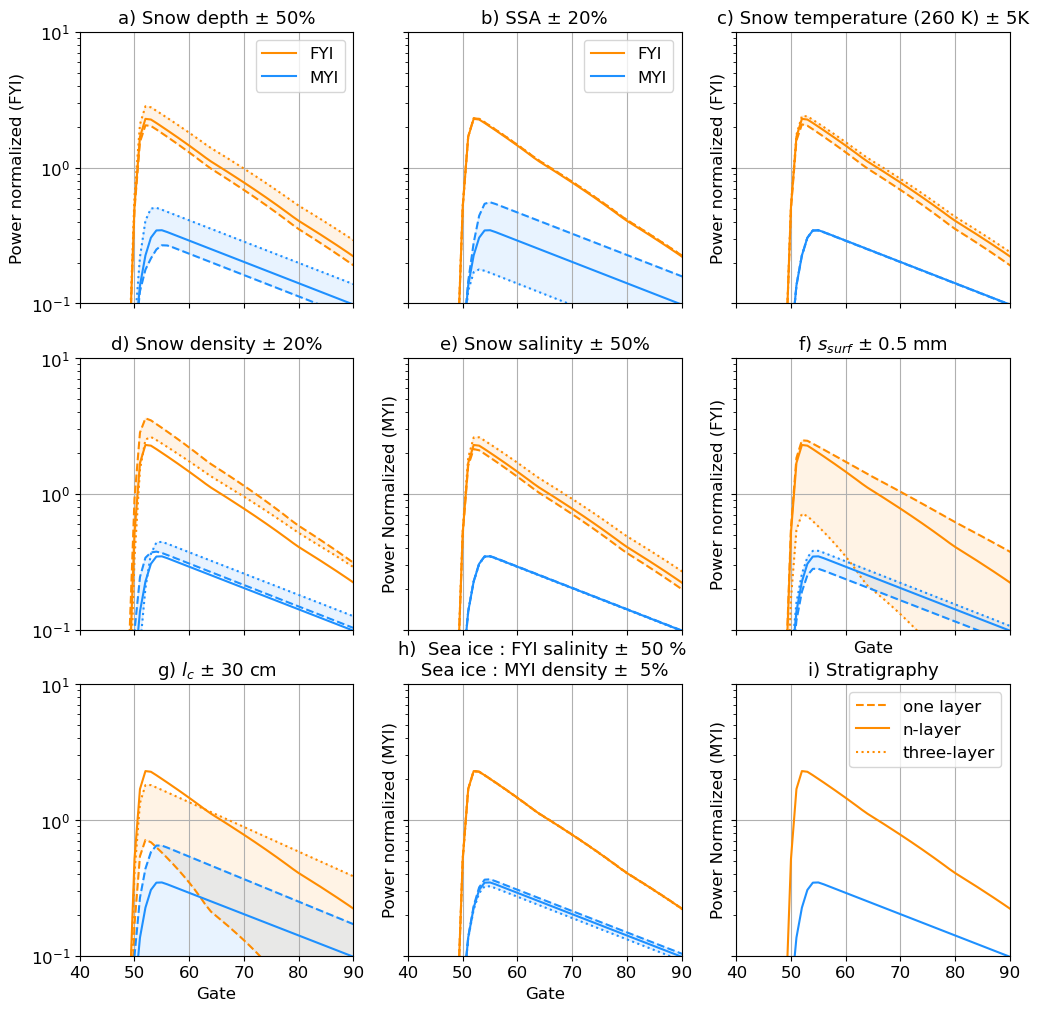

In [84]:
#generate x fro number of bins
x = range(0,len(res_CB_Ka_depth_p50))

# Plot results
plt.close()
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=(12,12), sharex = True, sharey = True)
plt.rcParams.update({'font.size': 12})
ax1.set_title('a) Snow depth ± 50%', size = 13)
ax1.plot(res_CB_Ka_depth_p50, linestyle = '--',color = 'darkorange')
ax1.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI')
ax1.plot(res_CB_Ka_depth_m50, linestyle = ':',color = 'darkorange')
ax1.fill_between(x, y1 = res_CB_Ka_depth_p50, y2 = res_CB_Ka_depth_m50, alpha =0.1, color = 'darkorange')

ax1.plot(res_A_Ka_depth_p50, linestyle = '--',color = 'dodgerblue')
ax1.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI')
ax1.plot(res_A_Ka_depth_m50, linestyle = ':',color = 'dodgerblue')
ax1.fill_between(x, y1 = res_A_Ka_depth_p50, y2 = res_A_Ka_depth_m50, alpha =0.1, color = 'dodgerblue')
ax1.legend()
#ax1.set_xlim(155,190)
ax1.set_ylabel('Power normalized (FYI)')
ax1.grid()


ax2.set_title('b) SSA ± 20%', size = 13)
ax2.plot(res_CB_Ka_ssa_p20, linestyle = '--',color = 'darkorange')
ax2.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14,color = 'darkorange', label = 'FYI')
ax2.plot(res_CB_Ka_ssa_m20, linestyle = ':',color = 'darkorange')

ax2.plot(res_A_Ka_ssa_p20, linestyle = '--',color = 'dodgerblue')
ax2.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14,color = 'dodgerblue', label = 'MYI')
ax2.plot(res_A_Ka_ssa_m20, linestyle = ':',color = 'dodgerblue')
ax2.fill_between(x, y1 = res_A_Ka_ssa_p20, y2 = res_A_Ka_ssa_m20, alpha =0.1, color = 'dodgerblue')
ax2.legend()
ax2.grid()
#ax2.set_xlim(155,190)

# ax8.set_title('c) Microstructure', size = 13)
# ax8.plot(res_CB_Ka_ind, linestyle = '--',color = 'darkorange', label = 'IND')
# ax8.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14,color = 'darkorange', label = 'EXP')
# ax8.plot(res_CB_Ka_shs, linestyle = ':',color = 'darkorange', label = 'SHS')

# ax8.plot(res_A_Ka_ind, linestyle = '--',color = 'dodgerblue')
# ax8.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14,color = 'dodgerblue')
# ax8.plot(res_A_Ka_shs, linestyle = ':',color = 'dodgerblue')
# ax8.legend()
# ax8.set_ylabel('Power Normalized (MYI)')
# ax8.grid()
# #ax8.set_xlim(155,190)


ax3.set_title('c) Snow temperature (260 K) ± 5K', size = 13)
ax3.plot(res_CB_Ka_temp_p10, linestyle = '--',color = 'darkorange')
ax3.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange')
ax3.plot(res_CB_Ka_temp_m10, linestyle = ':',color = 'darkorange')
ax3.fill_between(x, y1 = res_CB_Ka_temp_p10, y2 = res_CB_Ka_temp_m10, alpha =0.1, color = 'darkorange')

ax3.plot(res_A_Ka_temp_p10, linestyle = '--',color = 'dodgerblue')
ax3.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue')
ax3.plot(res_A_Ka_temp_m10, linestyle = ':',color = 'dodgerblue')
ax3.fill_between(x, y1 = res_A_Ka_temp_p10, y2 = res_A_Ka_temp_m10, alpha =0.1, color = 'dodgerblue')
ax3.grid()
#ax3.set_xlim(155,190)
ax3.set_ylabel('Power normalized (FYI)')


ax4.set_title('d) Snow density ± 20%', size = 13)
ax4.plot(res_CB_Ka_density_p20, linestyle = '--',color = 'darkorange')
ax4.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax4.plot(res_CB_Ka_density_m20, linestyle = ':',color = 'darkorange')
ax4.fill_between(x, y1 = res_CB_Ka_density_p20, y2 = res_CB_Ka_density_m20, alpha =0.1, color = 'darkorange')

ax4.plot(res_A_Ka_density_p20, linestyle = '--',color = 'dodgerblue')
ax4.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax4.plot(res_A_Ka_density_m20, linestyle = ':',color = 'dodgerblue')
ax4.fill_between(x, y1 = res_A_Ka_density_p20, y2 = res_A_Ka_density_m20, alpha =0.1, color = 'dodgerblue')
#ax8.legend()
ax4.grid()
#ax4.set_xlim(155,190)


ax5.set_title('e) Snow salinity ± 50%', size = 13)
ax5.plot(res_CB_Ka_salt_p50, linestyle = '--',color = 'darkorange')
ax5.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax5.plot(res_CB_Ka_salt_m50, linestyle = ':',color = 'darkorange')
ax5.fill_between(x, y1 = res_CB_Ka_salt_p50, y2 = res_CB_Ka_salt_m50, alpha =0.1, color = 'darkorange')

ax5.plot(res_A_Ka_salt_p50, linestyle = '--',color = 'dodgerblue')
ax5.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax5.plot(res_A_Ka_salt_m50, linestyle = ':',color = 'dodgerblue')
ax5.fill_between(x, y1 = res_A_Ka_salt_p50, y2 = res_A_Ka_salt_m50, alpha =0.1, color = 'dodgerblue')
#ax8.legend()
ax5.set_ylabel('Power Normalized (MYI)')
ax5.grid()
#ax5.set_xlim(155,190)

ax6.set_title('f) $s_{surf}$ ± 0.5 mm', size =13)
ax6.plot(res_CB_Ka_rough_p1, linestyle = '--',color = 'darkorange')
ax6.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax6.plot(res_CB_Ka_rough_m1, linestyle = ':',color = 'darkorange')
ax6.fill_between(x, y1 = res_CB_Ka_rough_p1, y2 = res_CB_Ka_rough_m1, alpha =0.1, color = 'darkorange')

ax6.plot(res_A_Ka_rough_p1, linestyle = '--',color = 'dodgerblue')
ax6.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax6.plot(res_A_Ka_rough_m1, linestyle = ':',color = 'dodgerblue')
ax6.fill_between(x, y1 = res_A_Ka_rough_p1, y2 = res_A_Ka_rough_m1, alpha =0.1, color = 'dodgerblue')
#ax4.legend()
ax6.set_xlabel('Gate')
ax6.set_ylabel('Power normalized (FYI)')
ax6.grid()


ax7.set_title('g) $l_c$ $\pm$ 30 cm', size =13)
ax7.plot(res_CB_Ka_rough_s_p1, linestyle = '--',color = 'darkorange')
ax7.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax7.plot(res_CB_Ka_rough_s_m1, linestyle = ':',color = 'darkorange')
ax7.fill_between(x, y1 = res_CB_Ka_rough_s_p1, y2 = res_CB_Ka_rough_s_m1, alpha =0.1, color = 'darkorange')

ax7.plot(res_A_Ka_rough_s_p1, linestyle = '--',color = 'dodgerblue')
ax7.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax7.plot(res_A_Ka_rough_s_m1, linestyle = ':',color = 'dodgerblue')
ax7.fill_between(x, y1 = res_A_Ka_rough_s_p1, y2 = res_A_Ka_rough_s_m1, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
#ax6.set_xlim(155,190)
ax7.set_xlabel('Gate')
ax7.grid()
#ax6.set_ylim(0,0.5)

ax8.set_title('h)  Sea ice : FYI salinity ±  50 % \n Sea ice : MYI density ±  5% ', size =13)
ax8.plot(res_CB_Ka_vf_p1, linestyle = '--',color = 'darkorange')
ax8.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14, color = 'darkorange', label = 'FYI ± 50%')
ax8.plot(res_CB_Ka_vf_m1, linestyle = ':',color = 'darkorange')
ax8.fill_between(x, y1 = res_CB_Ka_vf_p1, y2 = res_CB_Ka_vf_m1, alpha =0.1, color = 'darkorange')

ax8.plot(res_A_Ka_vf_p1, linestyle = '--',color = 'dodgerblue')
ax8.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14, color = 'dodgerblue', label = 'MYI ± 50%')
ax8.plot(res_A_Ka_vf_m1, linestyle = ':',color = 'dodgerblue')
ax8.fill_between(x, y1 = res_A_Ka_vf_p1, y2 = res_A_Ka_vf_m1, alpha =0.1, color = 'dodgerblue')
#ax3.legend()
#ax6.set_xlim(155,190)
ax8.set_xlabel('Gate')
ax8.set_ylabel('Power normalized (MYI)')
ax8.grid()
#ax6.set_ylim(0,0.5)

ax9.set_title('i) Stratigraphy', size = 13)
ax9.plot(res_CB_Ka_one, linestyle = '--',color = 'darkorange', label = 'one layer')
ax9.plot(mean_simu_CB_Ka.sel(contribution = 'total')/1e-14,color = 'darkorange', label = 'n-layer')
ax9.plot(res_CB_Ka_three, linestyle = ':',color = 'darkorange', label = 'three-layer')

ax9.plot(res_A_Ka_one, linestyle = '--',color = 'dodgerblue')
ax9.plot(mean_simu_A_Ka.sel(contribution = 'total')/1e-14,color = 'dodgerblue')
ax9.plot(res_A_Ka_three, linestyle = ':',color = 'dodgerblue')
ax9.legend()
ax9.set_ylabel('Power Normalized (MYI)')
ax9.grid()
#ax9.set_xlim(155,190)

ax1.set_yscale('log')
ax1.set_ylim(10e-2, 10)
ax1.set_xlim(40,90)


# plt.savefig('C://Users/julie/OneDrive - USherbrooke/post-doc/AKROSS/article/fig_output/sensitivity_analysis_Ka.png',
#              dpi=300, format='png', bbox_inches='tight')